In [ ]:
# Download the dataset
!kaggle datasets download -d noamsegal/affectnet-training-data

import zipfile

with zipfile.ZipFile("affectnet-training-data.zip", "r") as zip_ref:
    zip_ref.extractall("affectnet_data")

Dataset URL: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
 98% 308M/314M [00:05<00:00, 70.8MB/s]
100% 314M/314M [00:05<00:00, 58.0MB/s]


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
import pandas as pd

# Load the CSV
data = pd.read_csv("affectnet_data/labels.csv")

# FIrst lines
print(data.head())
print(data.columns)

# Distribution of the emotions
print(data['label'].value_counts())

   Unnamed: 0                     pth     label    relFCs
0           0  anger/image0000006.jpg  surprise  0.873142
1           1  anger/image0000060.jpg     anger  0.852311
2           2  anger/image0000061.jpg     anger  0.800957
3           3  anger/image0000066.jpg   disgust  0.843079
4           4  anger/image0000106.jpg     anger  0.849108
Index(['Unnamed: 0', 'pth', 'label', 'relFCs'], dtype='object')
label
surprise    4616
happy       4336
anger       3608
disgust     3472
contempt    3244
fear        3043
sad         2995
neutral     2861
Name: count, dtype: int64


In [ ]:
# Mapping
class_mapping = {
    'neutral': 0,
    'happy': 1,
    'sad': 2,
    'surprise': 3,
    'fear': 4,
    'disgust': 5,
    'anger': 6,
    'contempt': 7
}

# Directory
base_dir = "affectnet_data/"

# Load images and labels
def load_images_and_labels(base_dir, class_mapping, target_size=(128, 128), max_images_per_class=None):
    X = []
    y = []
    for class_name, class_idx in class_mapping.items():
        folder_path = os.path.join(base_dir, class_name)
        image_count = 0
        for img_name in os.listdir(folder_path):
            if max_images_per_class and image_count >= max_images_per_class:
                break
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                X.append(img)
                y.append(class_idx)
                image_count += 1
    return np.array(X), np.array(y)

# Loads
X, y = load_images_and_labels(base_dir, class_mapping, target_size=(128, 128), max_images_per_class=1000)

# Shapes
print("X Shape (images):", X.shape)
print("y Shape (labels):", y.shape)

X Shape (images): (8000, 128, 128, 3)
y Shape (labels): (8000,)


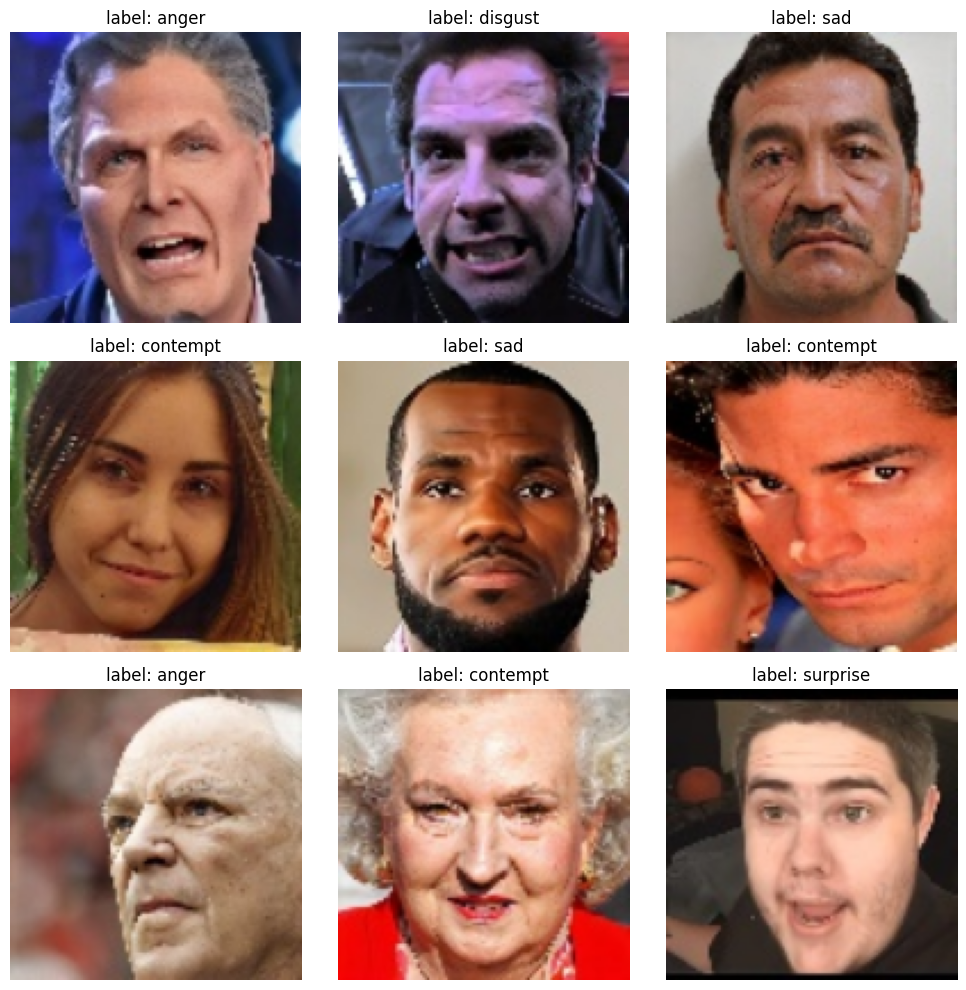

In [ ]:
import matplotlib.pyplot as plt

# Visualization
def visualize_images_with_labels(X, y, class_mapping, num_images=9):

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        image = X[idx]
        label = y[idx]
        class_name = list(class_mapping.keys())[list(class_mapping.values()).index(label)]

        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"label: {class_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


visualize_images_with_labels(X, y, class_mapping, num_images=9)

In [ ]:
# Split 80/20 and 50/50 for validation and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Train shape:", X_train.shape)
print("Validation test:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (6400, 128, 128, 3)
Validation test: (800, 128, 128, 3)
Test shape: (800, 128, 128, 3)


In [ ]:
# Feature extraction with resnet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
def extract_features(model, X):
    X_preprocessed = preprocess_input(X)  # Preprocess
    features = model.predict(X_preprocessed, batch_size=64, verbose=1)
    return features.reshape(features.shape[0], -1)  # Flatten

# Extraction
print("Extraction with ResNet50...")
X_train_features = extract_features(resnet_model, X_train)
X_val_features = extract_features(resnet_model, X_val)
X_test_features = extract_features(resnet_model, X_test)

print("Features:")
print("Train:", X_train_features.shape)
print("Validation:", X_val_features.shape)
print("Test:", X_test_features.shape)

Extraction with ResNet50...
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Features:
Train: (6400, 32768)
Validation: (800, 32768)
Test: (800, 32768)


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)
X_test_scaled = scaler.transform(X_test_features)


In [ ]:
# SVM training
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
print("SVM training...")
svm_model.fit(X_train_scaled, y_train)

SVM training...


SVC(class_weight='balanced', random_state=42)

In [ ]:
# Predictions / Evaluation
print("Evaluating validation data...")
y_val_pred = svm_model.predict(X_val_scaled)
print("\nClassification report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=list(class_mapping.keys())))

print("Evaluating test data...")
y_test_pred = svm_model.predict(X_test_scaled)
print("\nClassification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=list(class_mapping.keys())))


Evaluating validation data...

Classification report (Validation):
              precision    recall  f1-score   support

     neutral       0.48      0.70      0.57        92
       happy       0.65      0.80      0.72       110
         sad       0.37      0.21      0.27       105
    surprise       0.35      0.31      0.33        95
        fear       0.49      0.37      0.42        91
     disgust       0.37      0.22      0.27       101
       anger       0.39      0.41      0.40       116
    contempt       0.31      0.48      0.38        90

    accuracy                           0.44       800
   macro avg       0.43      0.44      0.42       800
weighted avg       0.43      0.44      0.42       800

Evaluating test data...

Classification report (Test):
              precision    recall  f1-score   support

     neutral       0.50      0.71      0.59       111
       happy       0.63      0.71      0.67       112
         sad       0.36      0.23      0.28        91
    surpri

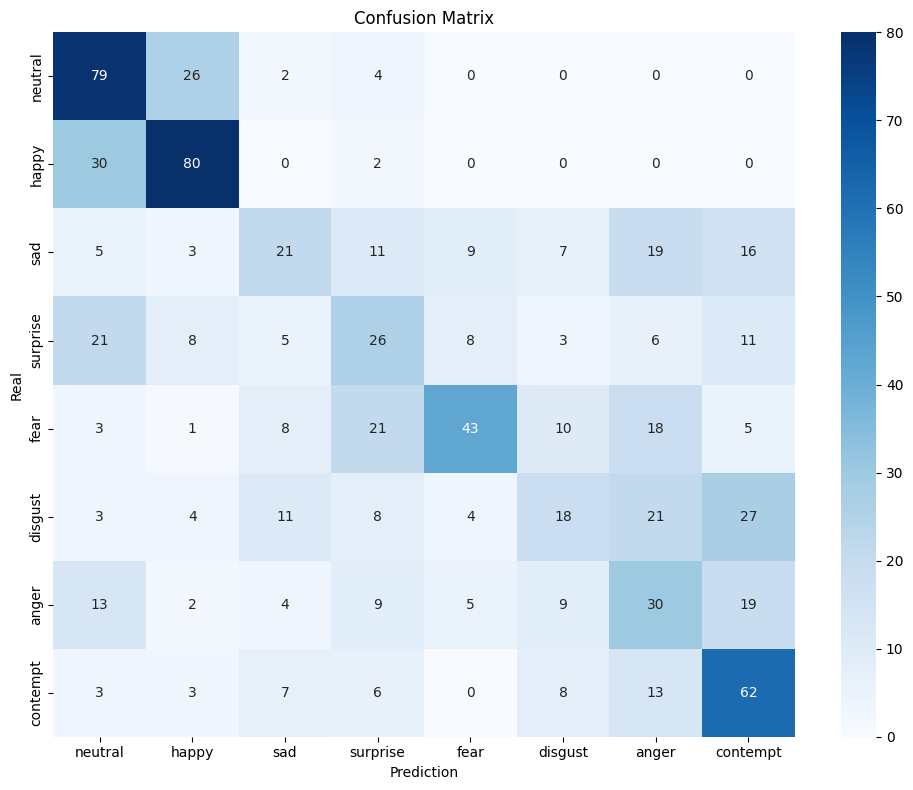

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()


class_names = list(class_mapping.keys())

plot_confusion_matrix(y_test, y_test_pred, class_names)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

joblib.dump(svm_model, "/content/drive/MyDrive/svm_affectnet_model.pkl")

Mounted at /content/drive


['/content/drive/MyDrive/svm_affectnet_model.pkl']